### import des bibliothèques

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

### import du dataset

In [41]:
df = pd.read_csv('..\data\dataset_new_score_v3.csv', index_col=0)
df.head()

,titre,budget,recette,duree,realisateur,casting,compagnies_production,suite,Comedy,Drama,...,director_score_sum,director_score_mean,director_score_med,director_score_min,director_score_max,compagnies_score_sum,compagnies_score_mean,compagnies_score_med,compagnies_score_min,compagnies_score_max
0,Dumb and Dumber To,40000000,169837010,110,"['Bobby Farrelly', 'Peter Farrelly']","['Jim Carrey', 'Jeff Daniels', 'Laurie Holden'...","['New Line Cinema', 'Universal Pictures', 'Con...",3,1,0,...,27,13.5,13,13,14,135,33.75,18,0,99
1,Марс,2000000,240000,100,['Anna Melikyan'],"['Nana Kiknadze', 'Artur Smolyaninov', 'Yevgen...","['Central Partnership', 'Studio SLON']",1,1,1,...,0,0.0,0,0,0,0,0.00,0,0,0
2,Captain America: The Winter Soldier,170000000,714766572,136,"['Anthony Russo', 'Joe Russo']","['Chris Evans', 'Scarlett Johansson', 'Sebasti...",['Marvel Studios'],2,0,0,...,128,64.0,64,64,64,81,81.00,81,81,81
3,Тот ещё Карлосон!,4000000,9938268,80,['Sarik Andreasyan'],"['Mikhail Galustyan', 'Igor Vernik', 'Mariya S...",['Enjoy Movies'],1,1,0,...,0,0.0,0,0,0,0,0.00,0,0,0
4,The Saint,68000000,118063304,116,['Phillip Noyce'],"['Val Kilmer', 'Elisabeth Shue', 'Rade Šerbedž...","['Paramount', 'Mace Neufeld Productions', 'Rys...",1,0,0,...,11,11.0,11,11,11,9,3.00,0,0,9


In [42]:
df['compagnies_score_mean'] = df['compagnies_score_mean'].map(int)
df['casting_score_mean'] = df['casting_score_mean'].map(int)
df['director_score_mean'] = df['director_score_mean'].map(int)
df['benefice global'] = df['benefice global'].map(int)
df.drop(columns = ['titre', 'realisateur', 'casting', 'compagnies_production', 'recette', 'budget'], inplace = True)

### Librairies pour la prédiction

In [74]:
from random import shuffle
from sklearn import tree, preprocessing, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score


### Création de catégorie de bénéfice global

In [44]:
df.describe()['benefice global']

count     4695.000000
mean       214.260490
std        562.405316
min        -98.000000
25%        -29.000000
50%         77.000000
75%        259.500000
max      12400.000000
Name: benefice global, dtype: float64

In [45]:
df['tranche benef'] = 0
df.loc[df['benefice global'] >= df['benefice global'].quantile(0.25), 'tranche benef'] = 1
df.loc[df['benefice global'] >= df['benefice global'].quantile(0.5), 'tranche benef'] = 2
df.loc[df['benefice global'] >= df['benefice global'].quantile(0.75), 'tranche benef'] = 3

In [46]:
df['tranche benef'].value_counts()

1    1185
2    1178
3    1174
0    1158
Name: tranche benef, dtype: int64

### creation d'un train et d'un texte

In [47]:
X = df.drop(columns = ['tranche benef', 'benefice global'])
Y = df['tranche benef']

division du dataset en un train et un test

In [48]:
"""
    Constant indicating the proportion of the dataset to use as training set.
"""

TRAINING_SET_RATIO = 0.9

In [49]:
ind = [i for i in range(df.shape[0])]
shuffle(ind)
X_train=X.iloc[ind[:int(TRAINING_SET_RATIO*df.shape[0])]]
Y_train=Y.iloc[ind[:int(TRAINING_SET_RATIO*df.shape[0])]]
X_test=X.iloc[ind[int(TRAINING_SET_RATIO*df.shape[0]):]]
Y_test=Y.iloc[ind[int(TRAINING_SET_RATIO*df.shape[0]):]]

### méthode du Decision Tree Classifier 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


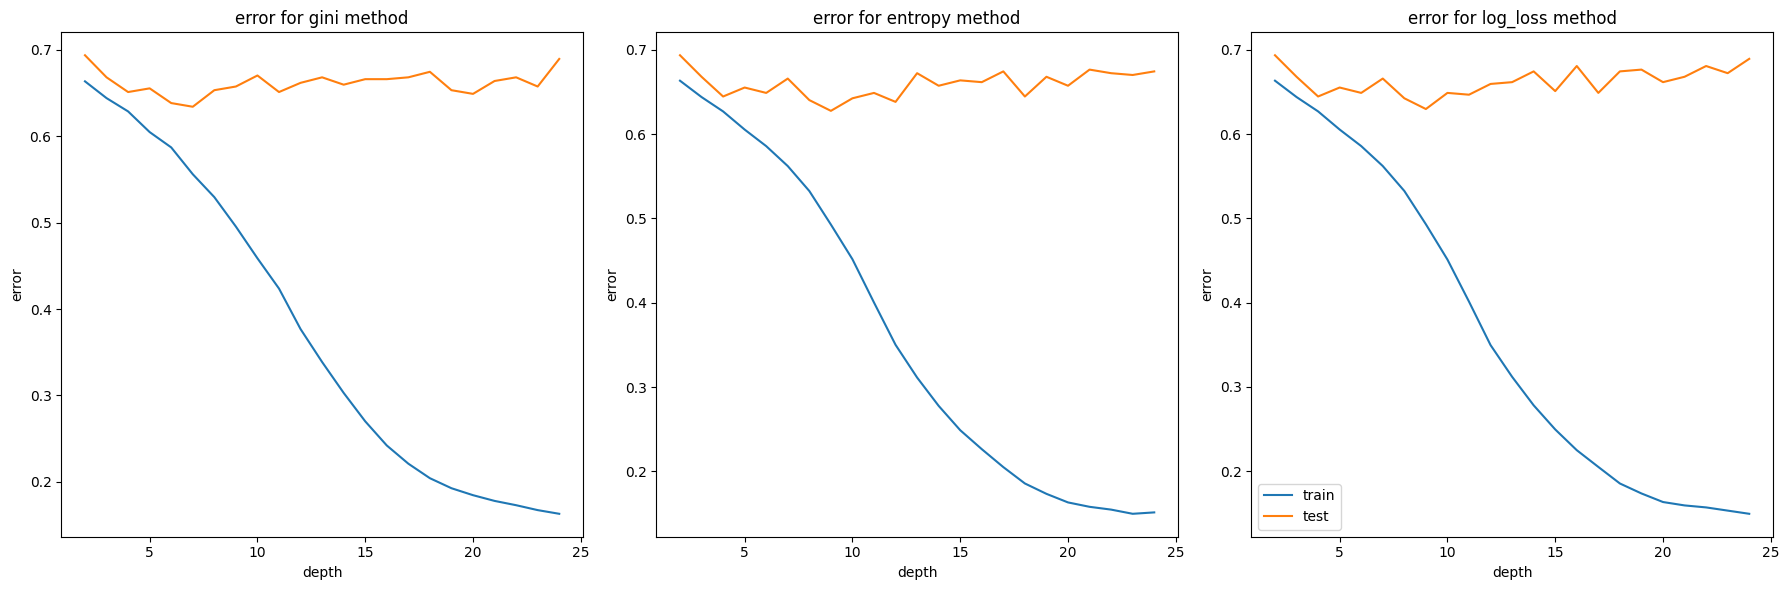

In [50]:
train_scores_dico = {}
test_scores_dico = {}
criteria = ["gini", "entropy", "log_loss"]
for criterion in ["gini", "entropy", "log_loss"]:
    train_scores = []
    test_scores = []
    depths = [i for i in range(2,25)]
    for depth in depths:
        clf = tree.DecisionTreeClassifier(criterion = criterion , max_depth = depth, min_samples_split = 2, min_samples_leaf = 2)
        clf = clf.fit(X_train, Y_train)
        train_score = clf.score(X_train, Y_train)
        train_scores.append(1 - train_score)
        test_score = clf.score(X_test,Y_test)
        test_scores.append(1 - test_score)
    train_scores_dico[criterion] = train_scores
    test_scores_dico[criterion] = test_scores

fig, ax = plt.subplots(1,3, figsize = (18,6))
for i, criterion in enumerate(criteria):
    ax[i].set_title(f'error for {criterion} method')
    ax[i].plot(depths, train_scores_dico[criterion], label=f"train")
    ax[i].plot(depths, test_scores_dico[criterion], label=f"test")
    ax[i].set_xlabel("depth")
    ax[i].set_ylabel("error")
    plt.legend()

fig.tight_layout()
plt.show()

In [51]:
clf = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 5, min_samples_split = 2, min_samples_leaf = 2)
clf.fit(X_train, Y_train)
Y_pred_test = clf.predict(X_test)

In [52]:
confusion_matrix(Y_test, Y_pred_test, labels=[0,1,2,3])

array([[54, 14, 10, 30],
       [40, 22, 32, 44],
       [24, 13, 37, 36],
       [14, 12, 39, 49]], dtype=int64)

In [53]:
print(classification_report(Y_test, Y_pred_test, digits = 4))

              precision    recall  f1-score   support

           0     0.4091    0.5000    0.4500       108
           1     0.3607    0.1594    0.2211       138
           2     0.3136    0.3364    0.3246       110
           3     0.3082    0.4298    0.3590       114

    accuracy                         0.3447       470
   macro avg     0.3479    0.3564    0.3387       470
weighted avg     0.3480    0.3447    0.3314       470



### méthode KNN Classifier

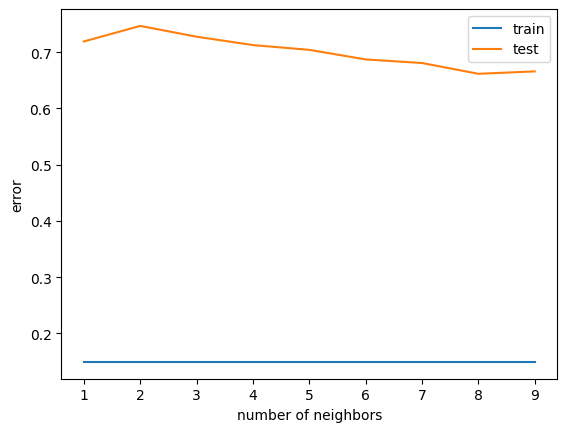

In [54]:
n_neighbors = [n for n in range(1,10)]
test_scores = []
train_scores = []
verify_scores = []

for n in n_neighbors:
    neigh = KNeighborsClassifier(n_neighbors = n)
    neigh.fit(X_train, Y_train)
    score_train = neigh.score(X_train, Y_train)
    score_test = neigh.score(X_test, Y_test)
    train_scores.append(1 - train_score)
    test_scores.append(1 - score_test)

fig, ax = plt.subplots()
ax.plot(n_neighbors, train_scores, label="train")
ax.plot(n_neighbors, test_scores, label="test")
ax.set_xlabel("number of neighbors")
ax.set_ylabel("error")
plt.legend()

In [55]:
neigh = KNeighborsClassifier(n_neighbors = 7)
neigh.fit(X_train, Y_train)
Y_pred_neigh_test = neigh.predict(X_test)

In [56]:
confusion_matrix(Y_test, Y_pred_neigh_test, labels=[0,1,2,3])

array([[58, 30, 11,  9],
       [46, 35, 39, 18],
       [32, 36, 24, 18],
       [28, 32, 21, 33]], dtype=int64)

In [57]:
print(classification_report(Y_test, Y_pred_test, digits = 4))

              precision    recall  f1-score   support

           0     0.4091    0.5000    0.4500       108
           1     0.3607    0.1594    0.2211       138
           2     0.3136    0.3364    0.3246       110
           3     0.3082    0.4298    0.3590       114

    accuracy                         0.3447       470
   macro avg     0.3479    0.3564    0.3387       470
weighted avg     0.3480    0.3447    0.3314       470



### methode du Dummy Classifier

In [58]:
Dum = DummyClassifier()
Dum.fit(X_train, Y_train)
test_score = Dum.score(X_test, Y_test)
print(f'test_score = {test_score}')

test_score = 0.23404255319148937


### methode de la Logistic Regression

création d'un score binaire pour les tranche de benefice globale sur df (0 : film à perte, 1 : film ayant un benefice global positif)

In [59]:
df['tranche benef binaire'] = 0
df.loc[df['benefice global'] > 0, 'tranche benef binaire'] = 1
df['tranche benef binaire'].value_counts()

1    3122
0    1573
Name: tranche benef binaire, dtype: int64

In [60]:
X_bin = df.drop(columns = ['tranche benef', 'benefice global', 'tranche benef binaire'])
Y_bin = df['tranche benef binaire']

In [61]:
ind = [i for i in range(df.shape[0])]
shuffle(ind)
X_train_bin=X_bin.iloc[ind[:int(TRAINING_SET_RATIO*df.shape[0])]]
Y_train_bin=Y_bin.iloc[ind[:int(TRAINING_SET_RATIO*df.shape[0])]]
X_test_bin=X_bin.iloc[ind[int(TRAINING_SET_RATIO*df.shape[0]):]]
Y_test_bin=Y_bin.iloc[ind[int(TRAINING_SET_RATIO*df.shape[0]):]]

In [62]:
stds = preprocessing.StandardScaler()

Z_train = stds.fit_transform(X_train_bin)

print(scipy.stats.describe(Z_train, axis=0, ddof=0))

DescribeResult(nobs=4225, minmax=(array([-2.23233655, -0.23066832, -0.72399605, -0.95395816, -0.3448317 ,
       -0.59986051, -0.61592746, -0.46419561, -0.34095212, -0.35294118,
       -0.35505788, -0.42368462, -0.46494873, -0.25712163, -0.3161866 ,
       -0.19252093, -0.18167921, -0.10719842, -0.24432357, -0.100203  ,
       -0.0266564 , -1.38865635, -0.67801062, -0.61622075, -0.06355187,
       -0.01646476, -0.93080207, -0.50042734, -0.5065859 , -0.50658206,
       -0.50330557, -0.50982759, -0.72548287, -0.60920434, -0.44747617,
       -0.2322986 , -0.7299516 ]), array([10.35440837, 28.08000991,  1.38122301,  1.04826401,  2.89996544,
        1.66705422,  1.62356782,  2.15426425,  2.93296313,  2.83333333,
        2.81644221,  2.36024618,  2.1507748 ,  3.88920997,  3.16268939,
        5.19424032,  5.50420715,  9.32849577,  4.09293304,  9.97974138,
       37.51444166,  1.39019102, 27.11795357, 15.21416254, 43.39417106,
       64.90958392,  3.25869471,  9.58532913,  7.77801028,  7.77698

In [66]:
logit = LogisticRegression()

parameters = [{'penalty':['l1','l2']}, 
              {'C':[1, 10, 100, 1000]}]



grid_search = GridSearchCV(estimator = logit,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)


grid_search.fit(Z_train, Y_train_bin)

c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'penalty': ['l1', 'l2']}, {'C': [1, 10, 100, 1000]}],
             scoring='accuracy')

In [67]:
# best score achieved during the GridSearchCV
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))

# print parameters that give the best results
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))

# print estimator that was chosen by the GridSearch
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))

GridSearch CV best score : 0.6705


Parameters that give the best results : 

 {'C': 10}


Estimator that was chosen by the search : 

 LogisticRegression(C=10)


In [69]:
logit = LogisticRegression(C=10, max_iter = 60)

#Starting calculations and no need to add the constant
logit.fit(Z_train,Y_train_bin)

# computing OR
print(pd.DataFrame({"var":X_train.columns,"coef":logit.coef_[0], "OR":np.exp(logit.coef_[0])}))

                      var      coef        OR
0                   duree  0.305143  1.356819
1                   suite  0.396176  1.486131
2                  Comedy  0.117534  1.124720
3                   Drama -0.104534  0.900744
4                  Horror  0.186597  1.205141
5                Thriller -0.008325  0.991710
6                  Action  0.058105  1.059827
7               Adventure -0.017800  0.982357
8         Science Fiction -0.069932  0.932458
9                 Fantasy -0.017046  0.983098
10                 Family  0.117971  1.125212
11                  Crime  0.011282  1.011346
12                Romance  0.045932  1.047003
13              Animation  0.014291  1.014393
14                Mystery -0.002733  0.997270
15                    War -0.052870  0.948503
16                  Music -0.013208  0.986879
17                Western -0.063590  0.938390
18                History -0.097993  0.906655
19            Documentary  0.088074  1.092069
20               TV Movie -0.02738

c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [70]:
# transforming the test sample

Z_test = stds.transform(X_test)

In [73]:
predlog_test = logit.predict(Z_test)

print(classification_report(Y_test_bin,predlog_test))

              precision    recall  f1-score   support

           0       0.34      0.12      0.18       149
           1       0.69      0.89      0.78       321

    accuracy                           0.65       470
   macro avg       0.51      0.51      0.48       470
weighted avg       0.58      0.65      0.59       470



In [75]:
stds = preprocessing.StandardScaler()

Z = stds.fit_transform(X) 

scores = cross_val_score(logit, Z_train, Y_train_bin, cv = 5, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))

Cross-validation scores:[0.68284024 0.67337278 0.66508876 0.6591716  0.67218935]


c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

In [76]:
print('Average cross-validation score: {:.4f}'.format(scores.mean()))

Average cross-validation score: 0.6705


In [77]:
print('Average cross-validation score: {:.4f}'.format(scores.std()))

Average cross-validation score: 0.0080


### Méthode SVM

In [78]:
# Extract some useful information
num_classes = 4
classes_labels = [0,1,2,3]

# Initialize classfier
clf = svm.SVC()
stds = preprocessing.StandardScaler()
Z_train = stds.fit_transform(X_train)
Z_test = stds.transform(X_test)
clf.fit(Z_train, Y_train)
Y_pred = clf.predict(Z_test)

In [79]:
print(classification_report(Y_test, Y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.3681    0.5556    0.4428       108
           1     0.3861    0.2826    0.3264       138
           2     0.3271    0.3182    0.3226       110
           3     0.4545    0.3947    0.4225       114

    accuracy                         0.3809       470
   macro avg     0.3840    0.3878    0.3786       470
weighted avg     0.3848    0.3809    0.3756       470



In [84]:
def precision_recall_multilabels(y_true, y_pred, labels):
    recalls = []
    precisions = []
    for label in labels:

        pos_true = y_true == label
        pos_pred = y_pred == label

        # By hand
        true_pos = pos_pred & pos_true
        recalls.append(np.sum(true_pos) / np.sum(pos_true))
        precisions.append(np.sum(true_pos) / np.sum(pos_pred))

        # With sklearn
        # precisions.append(precision_score(pos_test, pos_pred))
        # recalls.append(recall_score(pos_test, pos_pred))

    return precisions, recalls

In [80]:
def kfold_multimodels_report(clfs_results: dict[str, dict[str, list[list[float]]]]):
    """
    Prints a report for the results of experiments on multiple models,
    each one evaluated using k-fold cross-validation.

    The results of the experiments should be given as the 'clfs_stats'
    argument, with the following structure:

    {
        "clf_name1": {"metric1": list[list], "metric2": list[list], ...},
        "clf_name2": {"metric1": list[list], "metric2": list[list], ...},
        ...
    }

    with each list[list] being of shape (num_folds, num_classes).
    """
    clfs_stats = kfold_summarize_results(clfs_results)
    with np.printoptions(precision=2, floatmode="fixed"):
        for clf_name, clf_stats in clfs_stats.items():
            print(f"{clf_name:<15}")
            for metric_name, stats in clf_stats.items():
                print(f"{metric_name:>15}")
                for stat_name, data in stats.items():
                    print(f"{stat_name:>20}: {data}")
                    
def kfold_summarize_results(clfs_results):
    """Computes stats on results of multi-models k-folds experiments.

    Takes:

    {
        "clf_name1": {"metric1": list[list], "metric2": list[list], ...},
        "clf_name2": {"metric1": list[list], "metric2": list[list], ...},
        ...
    }

    Returns:

    {
        "clf_name1": {"metric1": {"mean": value, "std": value ...}, ...},
        ...
    }
    """
    clfs_stats = {clf_name: {} for clf_name in clfs_results}
    for clf_name, clf_results in clfs_results.items():
        for metric, data in clf_results.items():
            clfs_stats[clf_name][metric] = {
                "mean": np.mean(data, axis=0),
                "std": np.std(data, axis=0),
            }
    return clfs_stats

In [81]:
def kfold_precisions_recalls(X, y, labels, clf, kf: KFold):
    """Returns the history of precisions and recalls through K-fold training

    Parameters
    ----------
    X, y : data
    labels : list[int]
    clf : classifier
    kf : KFold instance

    Returns
    -------
    precisions : list[list], shape (num_folds, len(labels))
    recalls : list[list], shape (num_folds, len(labels))
    """
    precisions, recalls = [], []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        precisions_, recalls_ = precision_recall_multilabels(y_test, y_pred, labels)

        precisions.append(precisions_)
        recalls.append(recalls_)

    return precisions, recalls

In [82]:
clfs = {
    "linear": svm.SVC(kernel="linear", C=1.0),
    "poly2": svm.SVC(kernel="poly", C=1.0, degree=2, gamma="scale", coef0=0.0),
    "poly3": svm.SVC(kernel="poly", C=1.0, degree=3, gamma="scale", coef0=0.0),
    "poly4": svm.SVC(kernel="poly", C=1.0, degree=4, gamma="scale", coef0=0.0),
    "rbf": svm.SVC(kernel="rbf", C=1.0, gamma="scale"),
    # "sigmoid": svm.SVC(kernel="sigmoid", C=1.0, gamma="scale", coef0=0.0),
}

clfs_results = {clf_name: {"precisions": None, "recalls": None} for clf_name in clfs}

In [85]:
kf = KFold(n_splits=10, shuffle=True, random_state=34)
num_classes = 4
classes_labels = [0,1,2,3,4]

for clf_name, clf in clfs.items():
    precisions, recalls = kfold_precisions_recalls(X, Y, classes_labels, clf, kf)

    clfs_results[clf_name]["precisions"] = precisions
    clfs_results[clf_name]["recalls"] = recalls

kfold_multimodels_report(clfs_results)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_5904\500844500.py:11: RuntimeWarning: invalid value encountered in longlong_scalars
  recalls.append(np.sum(true_pos) / np.sum(pos_true))
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_5904\500844500.py:12: RuntimeWarning: invalid value encountered in longlong_scalars
  precisions.append(np.sum(true_pos) / np.sum(pos_pred))
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_5904\500844500.py:11: RuntimeWarning: invalid value encountered in longlong_scalars
  recalls.append(np.sum(true_pos) / np.sum(pos_true))
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_5904\500844500.py:12: RuntimeWarning: invalid value encountered in longlong_scalars
  precisions.append(np.sum(true_pos) / np.sum(pos_pred))
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_5904\500844500.py:11: RuntimeWarning: invalid value encountered in longlong_scalars
  recalls.append(np.sum(true_pos) / np.sum(pos_true))
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_5904

linear         
     precisions
                mean: [0.37 0.30 0.35 0.40  nan]
                 std: [0.04 0.05 0.06 0.07  nan]
        recalls
                mean: [0.67 0.30 0.16 0.30  nan]
                 std: [0.04 0.04 0.03 0.06  nan]
poly2          
     precisions
                mean: [0.30 0.24 0.33 0.46  nan]
                 std: [0.03 0.04 0.04 0.12  nan]
        recalls
                mean: [0.80 0.12 0.23 0.10  nan]
                 std: [0.02 0.05 0.05 0.03  nan]
poly3          
     precisions
                mean: [0.30 0.25 0.32 0.47  nan]
                 std: [0.03 0.05 0.05 0.12  nan]
        recalls
                mean: [0.85 0.10 0.19 0.09  nan]
                 std: [0.02 0.04 0.05 0.03  nan]
poly4          
     precisions
                mean: [0.29 0.25 0.32 0.43  nan]
                 std: [0.02 0.08 0.04 0.14  nan]
        recalls
                mean: [0.88 0.07 0.17 0.09  nan]
                 std: [0.02 0.03 0.05 0.03  nan]
rbf            
     pre

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_5904\500844500.py:11: RuntimeWarning: invalid value encountered in longlong_scalars
  recalls.append(np.sum(true_pos) / np.sum(pos_true))
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_5904\500844500.py:12: RuntimeWarning: invalid value encountered in longlong_scalars
  precisions.append(np.sum(true_pos) / np.sum(pos_pred))
